# SAE features analysis

In [36]:
import torch
from sae_lens import SAE
from cuml import UMAP
import numpy as np

import matplotlib.pyplot as plt


In [3]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(device)

cuda


In [4]:
sae, cfg_dict, sparsity = SAE.from_pretrained(
    release = "gemma-scope-2b-pt-res",
    sae_id = "layer_20/width_16k/average_l0_71",
    device = device,
)

## Comparing $W_{enc}$ and $W_{dec}$

$W_{enc}=W_{dec}^\top$ at initialization. Here we want to evaluate how much they differ after training.

In [18]:
# We want a shape of (n_features, d_model)
W_enc = sae.W_enc.detach().T
W_dec = sae.W_dec.detach()

print(W_enc.shape)
print(W_dec.shape)

torch.Size([16384, 2304])
torch.Size([16384, 2304])


### UMAP

In [15]:
umap = UMAP(
    n_components=2,
    n_neighbors=15,
    metric='euclidean'
)

In [21]:
sae.eval()

with torch.no_grad():
    W_enc_umap = umap.fit_transform(W_enc)
    W_dec_umap = umap.fit_transform(W_dec)


Unprocessed data points

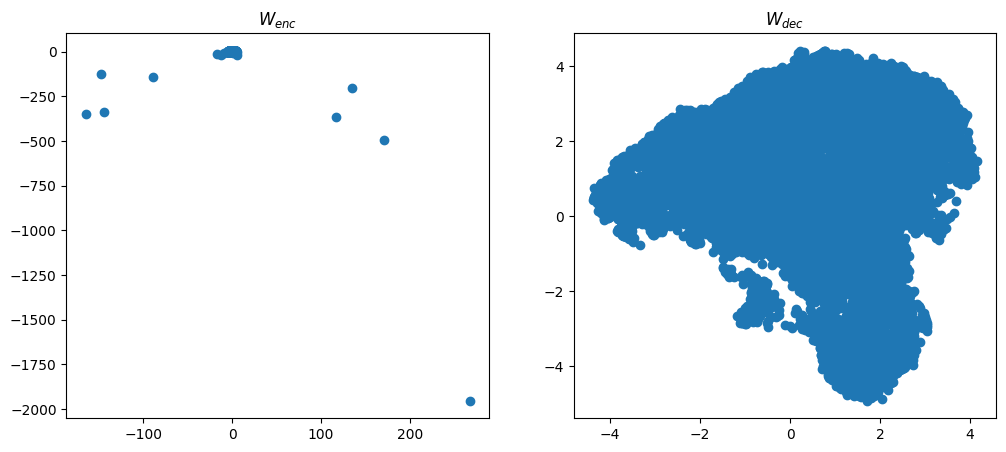

In [41]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

ax1.scatter(W_enc_umap[:, 0].get(), W_enc_umap[:, 1].get(), label="W_enc")
ax1.set_title("$W_{enc}$")

ax2.scatter(W_dec_umap[:, 0].get(), W_dec_umap[:, 1].get(), label="W_dec")
ax2.set_title("$W_{dec}$")

plt.show()

Removing outliers and adding color to get a better sense of the data

In [34]:
def generate_colors(data):
    max_x = max(data[:,0])
    min_x = min(data[:,0])
    max_y = max(data[:,1])
    min_y = min(data[:,1])

    colors = np.empty((0,3))
    for x,y in data:
        x_norm = (x-min_x)/(max_x-min_x)
        y_norm = (y-min_y)/(max_y-min_y)

        r = (1-y_norm)
        g = x_norm
        b = y_norm*(1-x_norm)

        colors = np.append(colors,[(r,g,b)],axis=0)
    
    return colors

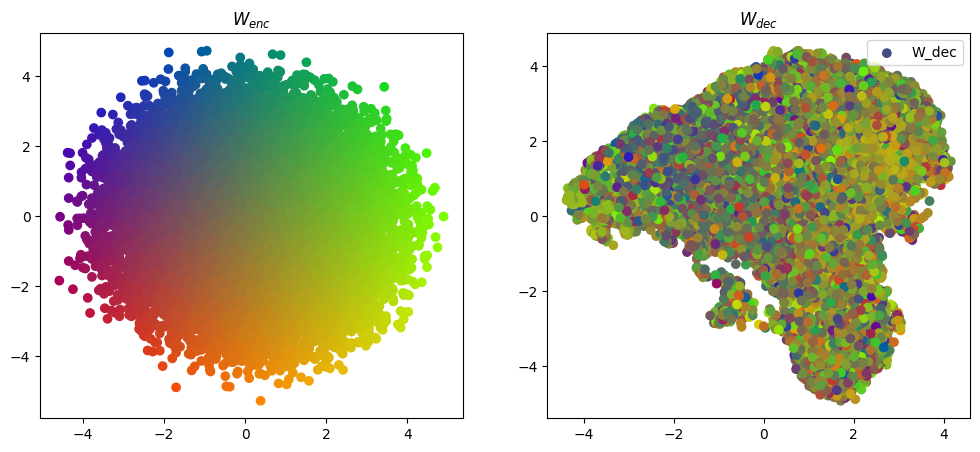

In [40]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

mask = (W_enc_umap[:, 0].get() >= -8) & (W_enc_umap[:, 0].get() <= 8) & (W_enc_umap[:, 1].get() >= -8) & (W_enc_umap[:, 1].get() <= 8)
colors = generate_colors(W_enc_umap[mask].get())

ax1.scatter(W_enc_umap[mask, 0].get(), W_enc_umap[mask, 1].get(), label="W_enc", c=colors)
ax1.set_title("$W_{enc}$")

ax2.scatter(W_dec_umap[mask, 0].get(), W_dec_umap[mask, 1].get(), label="W_dec", c=colors)
ax2.set_title("$W_{dec}$")

plt.show()